## Cashtag Counts

The following script reveals cashtag mentions on Twitter over time.

#### Outcome 
* Results folder that contains a .csv file for each cashtag
* Charts folder that contains a graph for each cashtag

In [1]:
import os
import sys
import yaml
import json
import requests
from requests_oauthlib import OAuth1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.dates as mdates
import seaborn as sns

In the root directory, create a new file entitled `credentials.yaml` and populate the information (as exemplified in `credentials.yaml.template`). The credentials must be tied to Twitter's Search API (Full Archive) at enterprise access. 

In [2]:
with open(r'./credentials.yaml') as file:
    credentials = yaml.load(file, Loader=yaml.FullLoader)
    
    username = credentials['enterprise_full_archive_search_credentials']['username']
    password = credentials['enterprise_full_archive_search_credentials']['password']
    account_name = credentials['enterprise_full_archive_search_credentials']['account_name']
    env_label = credentials['enterprise_full_archive_search_credentials']['env_label']

In [3]:
endpoint = f'https://gnip-api.twitter.com/search/fullarchive/accounts/{account_name}/{env_label}/counts.json'

The following cell is where you can specify the data you want to get back: 
* What stock you want to track (e.g. TWTTR) 
* What time period you'd like to pull data for (format: YYYYMMddHHmm)
* What time bucket you want to use (options: 'day', 'hour', 'minute')

In [4]:
stock = 'TWTR'
fromDate = '202001010000'
toDate = '202103040000'
bucket = 'hour'

# Only change parameters above this line 

body = {
    'query': f'${stock}', 
    'fromDate': f'{fromDate}',
    'toDate': f'{toDate}',
    'bucket': f'{bucket}'
}

In [5]:
response = requests.post(url=endpoint, auth=(username, password), json=body)
data = response.json()

timePeriods = []
counts = []
if 'error' in data:
    print(data)
else:
    totalCount = data['totalCount']
    print("Activity count:", totalCount)
    for result in data['results']:
        timePeriods.append(result['timePeriod'])
        counts.append(result['count'])

Activity count: 39379


In [6]:
request_count = 1
while 'next' in data.keys():
    next_token = data['next']
    body.update(next=next_token)
    try: 
        response = requests.post(url=endpoint, auth=(username, password), json=body)
        data = response.json()
        print("Activity count:", data['totalCount'])
        totalCount += data['totalCount']
        for result in data['results']:
            timePeriods.append(result['timePeriod'])
            counts.append(result['count'])
    except requests.exceptions.RequestException as e:
        print(e)
    request_count += 1
    data = response.json()

print(f'Job complete: {request_count} request(s) in total')
print('Total activity count:', totalCount)

Activity count: 51292
Activity count: 13734
Activity count: 16910
Activity count: 31169
Activity count: 17185
Activity count: 20983
Activity count: 29366
Activity count: 18682
Activity count: 23926
Activity count: 11660
Activity count: 14111
Activity count: 14373
Activity count: 8397
Job complete: 14 request(s) in total
Total activity count: 311167


In [7]:
df = pd.DataFrame({'Time period':timePeriods, 'Count':counts})

In [8]:
df['Time period'] = pd.to_datetime(df['Time period'])

In [9]:
df.head()

,Time period,Count
0,2021-02-01 00:00:00,20
1,2021-02-01 01:00:00,23
2,2021-02-01 02:00:00,11
3,2021-02-01 03:00:00,14
4,2021-02-01 04:00:00,12


In [10]:
df.sort_values(by='Time period')

,Time period,Count
9672,2020-01-01 00:00:00,5
9673,2020-01-01 01:00:00,7
9674,2020-01-01 02:00:00,5
9675,2020-01-01 03:00:00,3
9676,2020-01-01 04:00:00,0
...,...,...
739,2021-03-03 19:00:00,77
740,2021-03-03 20:00:00,81
741,2021-03-03 21:00:00,51
742,2021-03-03 22:00:00,77


In [11]:
df.to_csv(f'Results/{stock}_counts.csv')

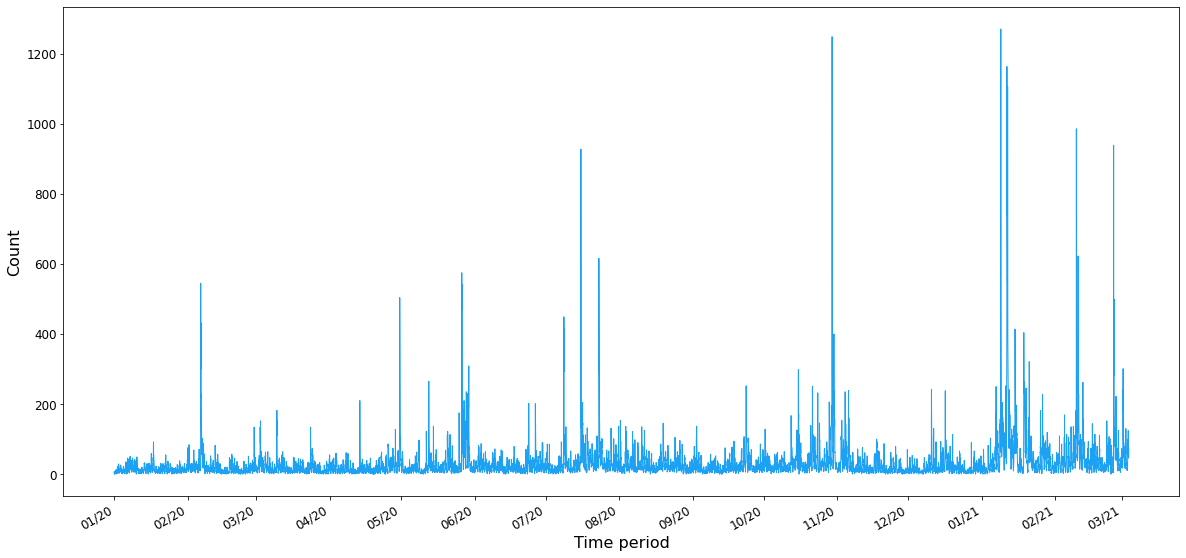

In [12]:
df = df.sort_values(by='Time period')

params = {
    'axes.labelsize' : 16,
    'xtick.labelsize' : 12,
    'ytick.labelsize' : 12,
    'figure.figsize' : (20,10)
}
pylab.rcParams.update(params)

fig, ax = plt.subplots()
ax.plot(df['Time period'], df['Count'], lw=1, ls='-', c='#1DA1F2', marker='o', ms=0)
fig.autofmt_xdate()

# For smaller datasets - display labels on x axis by day
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y')) 
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# For larger datasets - display labels on x axis by month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y')) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax.set_xlabel("Time period")
ax.set_ylabel("Count")

plt.savefig(f'Charts/{stock}', dpi=300)